# **Data Cleaning NoteBook**

## Objectives

* Evaluate missing data
* Clean data

## Inputs

* outputs/datasets/collection/house_price_records.csv 

## Outputs

* Generate cleaned Train and test sets, both saved under outputs/datasets/cleaned 

## Conclusions

* Data Cleaning Pipeline
* Drop Variables: ['EnclosedPorch', 'WoodDeckSF']


---

# Change working directory

In [1]:
import numpy
import os

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

Change the working directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

# Load Collected data

In [5]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/house_price_records.csv"
df = pd.read_csv(df_raw_path)
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,1,706,6.0,150,0.0,548,2.0,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,4,978,5.0,284,NaN,460,2.0,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,2,486,6.0,434,0.0,608,2.0,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,1,216,5.0,540,NaN,642,1.0,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,3,655,6.0,490,0.0,836,2.0,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# Data Exploration

In [6]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

Set Kaggle Dataset and Download it

In [7]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [10]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.045  0.097  0.0  0.0  0.0  0.038  0.702


Display at Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



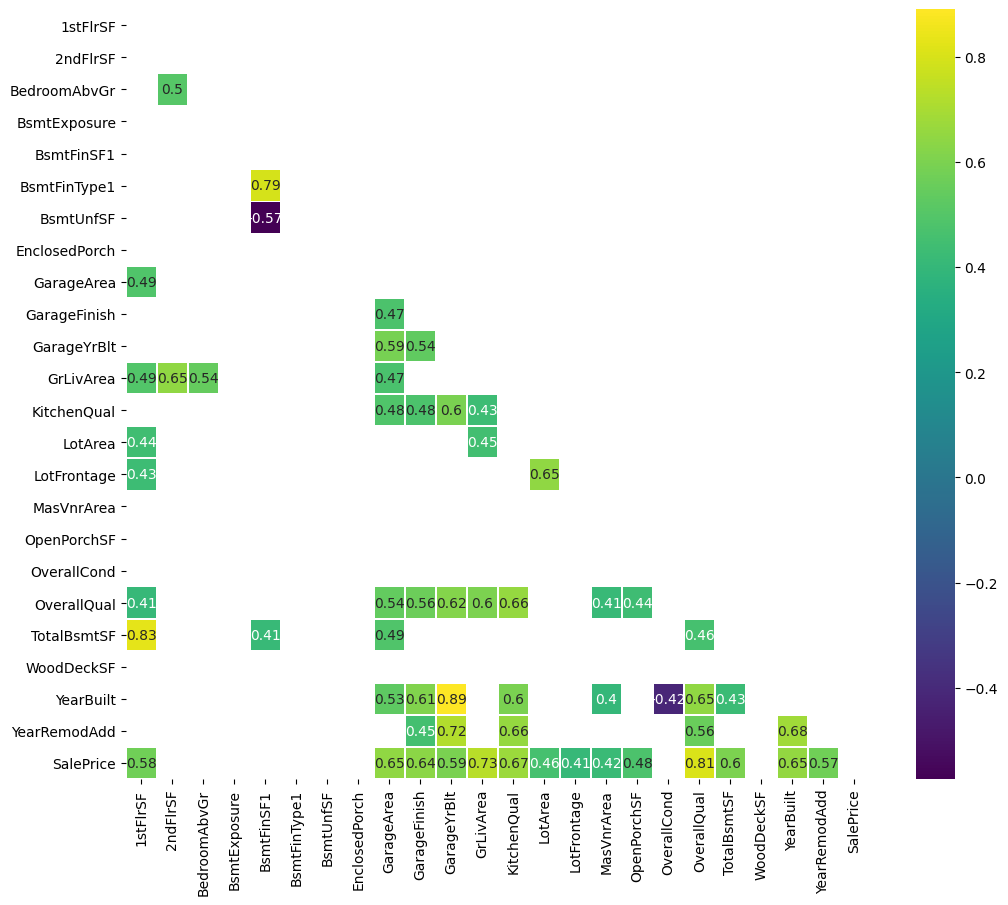



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



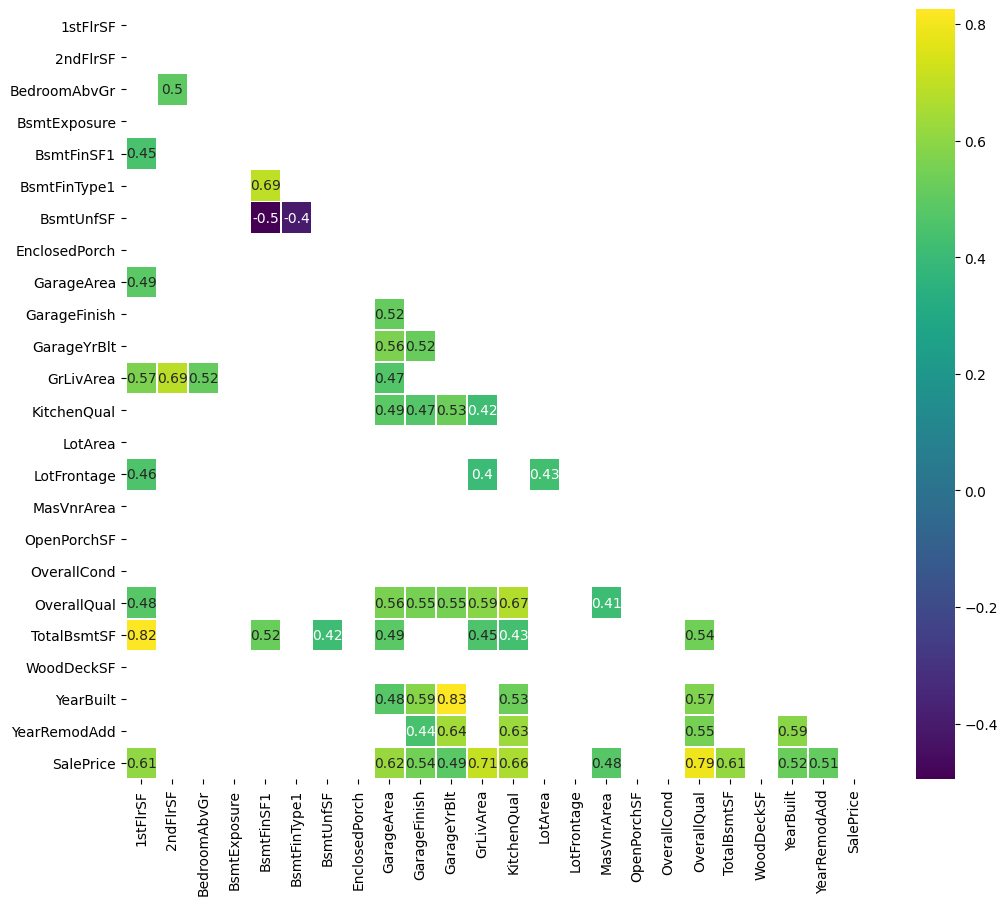



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



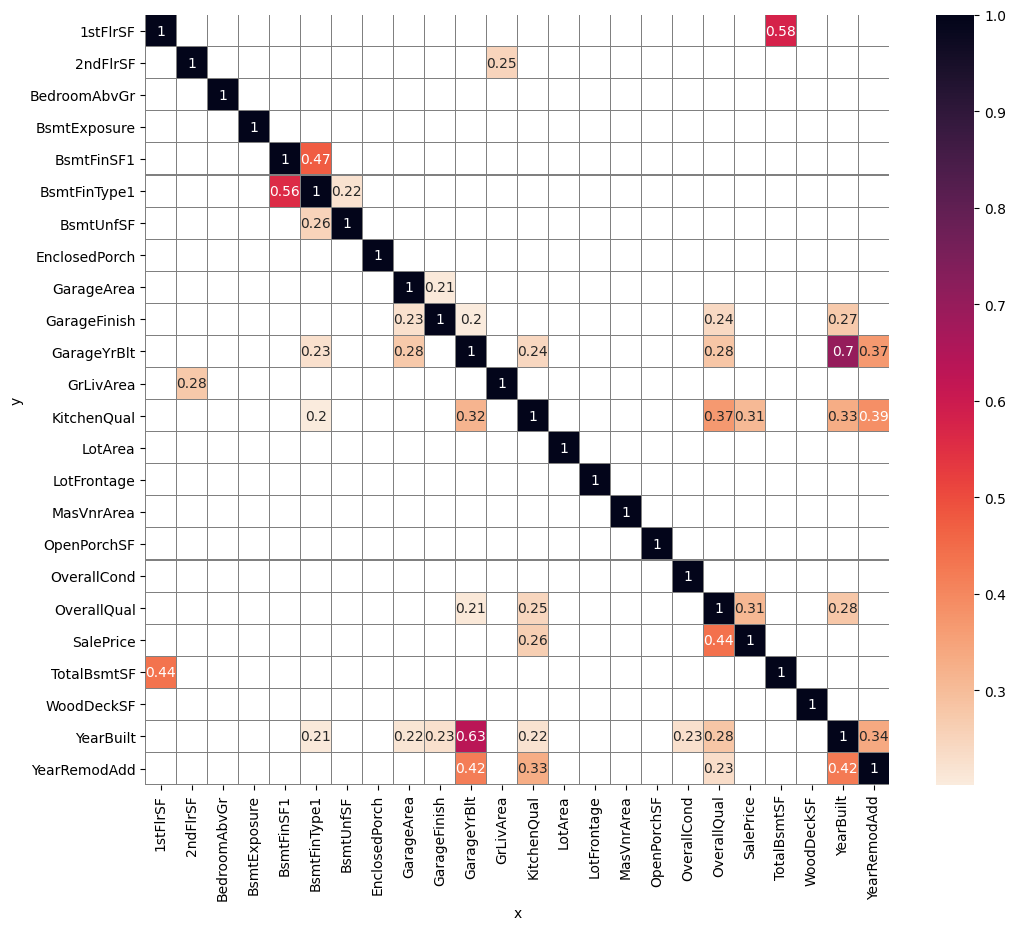

In [11]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

# Data Cleaning

## Assissing Missing Data Levels

In [12]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [13]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,float64
BsmtFinType1,114,7.81,float64
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Data Cleaning Summary

*Drop - ['EnclosedPorch', 'WoodDeckSF']*

## Split Train and Test Set

In [15]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [16]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,float64
BsmtFinType1,89,7.62,float64
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


## Drop Variables

In [17]:
variables_method = ['EnclosedPorch', 'WoodDeckSF' ]

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


In [18]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

In [19]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

In [8]:
df_house_prices_records = pd.read_csv(f"inputs/heritage-housing-issues/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
df_house_prices_records.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


#### DataFrame Summary

*Checking & removing duplicates*

In [9]:
df_house_prices_records.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694.0,3.0,No,0,Unf,953,NaN,460,RFn,...,62.0,0.0,40,5,6,953,0.0,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,NaN,500,Unf,...,85.0,119.0,0,6,6,1542,NaN,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,NaN,252,RFn,...,66.0,0.0,60,9,7,1152,NaN,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,112.0,240,Unf,...,68.0,0.0,0,6,5,1078,NaN,1950,1996,142125


In [10]:
df_house_prices_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   int64  
 1   2ndFlrSF       1374 non-null   float64
 2   BedroomAbvGr   1361 non-null   float64
 3   BsmtExposure   1460 non-null   object 
 4   BsmtFinSF1     1460 non-null   int64  
 5   BsmtFinType1   1346 non-null   object 
 6   BsmtUnfSF      1460 non-null   int64  
 7   EnclosedPorch  136 non-null    float64
 8   GarageArea     1460 non-null   int64  
 9   GarageFinish   1298 non-null   object 
 10  GarageYrBlt    1379 non-null   float64
 11  GrLivArea      1460 non-null   int64  
 12  KitchenQual    1460 non-null   object 
 13  LotArea        1460 non-null   int64  
 14  LotFrontage    1201 non-null   float64
 15  MasVnrArea     1452 non-null   float64
 16  OpenPorchSF    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  OverallQ

*Converting 1stFlrSF	, BsmtFinSF1, BsmtUnfSF, GarageArea, GrLivArea, LotArea, OpenPorchSF, TotalBsmtSF to float*

In [11]:
df_house_prices_records['1stFlrSF'] = df_house_prices_records['1stFlrSF'].astype(float)
df_house_prices_records['BsmtFinSF1'] = df_house_prices_records['BsmtFinSF1'].astype(float)
df_house_prices_records['BsmtUnfSF'] = df_house_prices_records['BsmtUnfSF'].astype(float)
df_house_prices_records['GarageArea'] = df_house_prices_records['GarageArea'].astype(float)
df_house_prices_records['GrLivArea'] = df_house_prices_records['GrLivArea'].astype(float)
df_house_prices_records['LotArea'] = df_house_prices_records['LotArea'].astype(float)
df_house_prices_records['OpenPorchSF'] = df_house_prices_records['OpenPorchSF'].astype(float)
df_house_prices_records['TotalBsmtSF'] = df_house_prices_records['TotalBsmtSF'].astype(float)
df_house_prices_records['TotalBsmtSF'] = df_house_prices_records['TotalBsmtSF'].astype(float)
df_house_prices_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1460 non-null   float64
 1   2ndFlrSF       1374 non-null   float64
 2   BedroomAbvGr   1361 non-null   float64
 3   BsmtExposure   1460 non-null   object 
 4   BsmtFinSF1     1460 non-null   float64
 5   BsmtFinType1   1346 non-null   object 
 6   BsmtUnfSF      1460 non-null   float64
 7   EnclosedPorch  136 non-null    float64
 8   GarageArea     1460 non-null   float64
 9   GarageFinish   1298 non-null   object 
 10  GarageYrBlt    1379 non-null   float64
 11  GrLivArea      1460 non-null   float64
 12  KitchenQual    1460 non-null   object 
 13  LotArea        1460 non-null   float64
 14  LotFrontage    1201 non-null   float64
 15  MasVnrArea     1452 non-null   float64
 16  OpenPorchSF    1460 non-null   float64
 17  OverallCond    1460 non-null   int64  
 18  OverallQ

*Dropping columns EnclosedPorch & WoodDeckSF*

In [12]:
df_house_prices_records.drop(['EnclosedPorch','WoodDeckSF'], axis=1, inplace=True)
df_house_prices_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   float64
 1   2ndFlrSF      1374 non-null   float64
 2   BedroomAbvGr  1361 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   float64
 5   BsmtFinType1  1346 non-null   object 
 6   BsmtUnfSF     1460 non-null   float64
 7   GarageArea    1460 non-null   float64
 8   GarageFinish  1298 non-null   object 
 9   GarageYrBlt   1379 non-null   float64
 10  GrLivArea     1460 non-null   float64
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   float64
 13  LotFrontage   1201 non-null   float64
 14  MasVnrArea    1452 non-null   float64
 15  OpenPorchSF   1460 non-null   float64
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

*Dropping all rows that have missing data*

In [13]:
df_house_prices_records.dropna(inplace=True)
df_house_prices_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      797 non-null    float64
 1   2ndFlrSF      797 non-null    float64
 2   BedroomAbvGr  797 non-null    float64
 3   BsmtExposure  797 non-null    object 
 4   BsmtFinSF1    797 non-null    float64
 5   BsmtFinType1  797 non-null    object 
 6   BsmtUnfSF     797 non-null    float64
 7   GarageArea    797 non-null    float64
 8   GarageFinish  797 non-null    object 
 9   GarageYrBlt   797 non-null    float64
 10  GrLivArea     797 non-null    float64
 11  KitchenQual   797 non-null    object 
 12  LotArea       797 non-null    float64
 13  LotFrontage   797 non-null    float64
 14  MasVnrArea    797 non-null    float64
 15  OpenPorchSF   797 non-null    float64
 16  OverallCond   797 non-null    int64  
 17  OverallQual   797 non-null    int64  
 18  TotalBsmtSF   797 non-null   

*Converting GarageYrBlt to int*

In [14]:
df_house_prices_records['GarageYrBlt'] = df_house_prices_records['GarageYrBlt'].astype(int)
df_house_prices_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      797 non-null    float64
 1   2ndFlrSF      797 non-null    float64
 2   BedroomAbvGr  797 non-null    float64
 3   BsmtExposure  797 non-null    object 
 4   BsmtFinSF1    797 non-null    float64
 5   BsmtFinType1  797 non-null    object 
 6   BsmtUnfSF     797 non-null    float64
 7   GarageArea    797 non-null    float64
 8   GarageFinish  797 non-null    object 
 9   GarageYrBlt   797 non-null    int64  
 10  GrLivArea     797 non-null    float64
 11  KitchenQual   797 non-null    object 
 12  LotArea       797 non-null    float64
 13  LotFrontage   797 non-null    float64
 14  MasVnrArea    797 non-null    float64
 15  OpenPorchSF   797 non-null    float64
 16  OverallCond   797 non-null    int64  
 17  OverallQual   797 non-null    int64  
 18  TotalBsmtSF   797 non-null   

*Converting BsmtExposure to int*

In [15]:
df_house_prices_records['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', 'None'], dtype=object)

In [16]:
df_house_prices_records['BsmtExposure'] = df_house_prices_records['BsmtExposure'].replace({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})

*Cheking BsmtExposure data type*

In [17]:
df_house_prices_records['BsmtExposure'].dtype

dtype('int64')

*Converting BsmtFinType1 to int*

In [18]:
df_house_prices_records['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'None', 'LwQ', 'BLQ'], dtype=object)

In [19]:
df_house_prices_records['BsmtFinType1'] = df_house_prices_records['BsmtFinType1'].replace({"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6})

*Cheking BsmtFinType1 data type*

In [20]:
df_house_prices_records['BsmtFinType1'].dtype

dtype('int64')

*Converting GarageFinish to int*

In [21]:
df_house_prices_records['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin'], dtype=object)

In [22]:
df_house_prices_records['GarageFinish'] = df_house_prices_records['GarageFinish'].replace({"None":0, "Unf":1, "RFn":2, "Fin":3})

*Cheking GarageFinish data type*

In [23]:
df_house_prices_records['GarageFinish'].dtype

dtype('int64')

*Converting KitchenQual to int*

In [24]:
df_house_prices_records['KitchenQual'].unique()

array(['Gd', 'TA', 'Fa', 'Ex'], dtype=object)

In [25]:
df_house_prices_records['KitchenQual'] = df_house_prices_records['KitchenQual'].replace({"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})

*Cheking KitchenQual data type*

In [26]:
df_house_prices_records['KitchenQual'].dtype

dtype('int64')

In [27]:
df_house_prices_records.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,1,706.0,6,150.0,548.0,2,2003,...,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003,208500
1,1262.0,0.0,3.0,4,978.0,5,284.0,460.0,2,1976,...,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976,181500
2,920.0,866.0,3.0,2,486.0,6,434.0,608.0,2,2001,...,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002,223500
5,796.0,566.0,1.0,1,732.0,6,64.0,480.0,1,1993,...,14115.0,85.0,0.0,30.0,5,5,796.0,1993,1995,143000
6,1694.0,0.0,3.0,3,1369.0,6,317.0,636.0,2,2004,...,10084.0,75.0,186.0,57.0,5,8,1686.0,2004,2005,307000


### Inherited houses

In [28]:
df_inherited_houses = pd.read_csv(f"inputs/heritage-housing-issues/house-price-20211124T154130Z-001/house-price/inherited_houses.csv")
df_inherited_houses.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


#### DataFrame Summary

In [29]:
df_inherited_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       4 non-null      int64  
 1   2ndFlrSF       4 non-null      int64  
 2   BedroomAbvGr   4 non-null      int64  
 3   BsmtExposure   4 non-null      object 
 4   BsmtFinSF1     4 non-null      float64
 5   BsmtFinType1   4 non-null      object 
 6   BsmtUnfSF      4 non-null      float64
 7   EnclosedPorch  4 non-null      int64  
 8   GarageArea     4 non-null      float64
 9   GarageFinish   4 non-null      object 
 10  GarageYrBlt    4 non-null      float64
 11  GrLivArea      4 non-null      int64  
 12  KitchenQual    4 non-null      object 
 13  LotArea        4 non-null      int64  
 14  LotFrontage    4 non-null      float64
 15  MasVnrArea     4 non-null      float64
 16  OpenPorchSF    4 non-null      int64  
 17  OverallCond    4 non-null      int64  
 18  OverallQual   

*Converting 1stFlrSF	, 2ndFlrSF, BedroomAbvGr, EnclosedPorch, GrLivArea, LotArea, OpenPorchSF, WoodDeckSF to float.*
*Converting GarageYrBlt to int.*

In [30]:
df_inherited_houses['1stFlrSF'] = df_inherited_houses['1stFlrSF'].astype(float)
df_inherited_houses['2ndFlrSF'] = df_inherited_houses['2ndFlrSF'].astype(float)
df_inherited_houses['BedroomAbvGr'] = df_inherited_houses['BedroomAbvGr'].astype(float)
df_inherited_houses['EnclosedPorch'] = df_inherited_houses['EnclosedPorch'].astype(float)
df_inherited_houses['GrLivArea'] = df_inherited_houses['GrLivArea'].astype(float)
df_inherited_houses['LotArea'] = df_inherited_houses['LotArea'].astype(float)
df_inherited_houses['OpenPorchSF'] = df_inherited_houses['OpenPorchSF'].astype(float)
df_inherited_houses['WoodDeckSF'] = df_inherited_houses['WoodDeckSF'].astype(float)
df_inherited_houses['GarageYrBlt'] = df_inherited_houses['GarageYrBlt'].astype(int)
df_inherited_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       4 non-null      float64
 1   2ndFlrSF       4 non-null      float64
 2   BedroomAbvGr   4 non-null      float64
 3   BsmtExposure   4 non-null      object 
 4   BsmtFinSF1     4 non-null      float64
 5   BsmtFinType1   4 non-null      object 
 6   BsmtUnfSF      4 non-null      float64
 7   EnclosedPorch  4 non-null      float64
 8   GarageArea     4 non-null      float64
 9   GarageFinish   4 non-null      object 
 10  GarageYrBlt    4 non-null      int64  
 11  GrLivArea      4 non-null      float64
 12  KitchenQual    4 non-null      object 
 13  LotArea        4 non-null      float64
 14  LotFrontage    4 non-null      float64
 15  MasVnrArea     4 non-null      float64
 16  OpenPorchSF    4 non-null      float64
 17  OverallCond    4 non-null      int64  
 18  OverallQual   

*Converting BsmtExposure to int*

In [31]:
df_inherited_houses['BsmtExposure'].unique()

array(['No'], dtype=object)

In [32]:
df_inherited_houses['BsmtExposure'] = df_inherited_houses['BsmtExposure'].replace({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})

*Cheking BsmtExposure data type*

In [33]:
df_inherited_houses['BsmtExposure'].dtype

dtype('int64')

*Converting BsmtFinType1 to int*

In [34]:
df_inherited_houses['BsmtFinType1'].unique()

array(['Rec', 'ALQ', 'GLQ'], dtype=object)

In [35]:
df_inherited_houses['BsmtFinType1'] = df_inherited_houses['BsmtFinType1'].replace({"None":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6})

*Cheking BsmtFinType1 data type*

In [36]:
df_inherited_houses['BsmtFinType1'].dtype

dtype('int64')

*Converting GarageFinish to int*

In [37]:
df_inherited_houses['GarageFinish'].unique()

array(['Unf', 'Fin'], dtype=object)

In [38]:
df_inherited_houses['GarageFinish'] = df_inherited_houses['GarageFinish'].replace({"None":0, "Unf":1, "RFn":2, "Fin":3})

*Cheking GarageFinish data type*

In [39]:
df_inherited_houses['GarageFinish'].dtype

dtype('int64')

*Converting KitchenQual to int*

In [40]:
df_inherited_houses['KitchenQual'].unique()

array(['TA', 'Gd'], dtype=object)

In [41]:
df_inherited_houses['KitchenQual'] = df_inherited_houses['KitchenQual'].replace({"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})

*Cheking KitchenQual data type*

In [42]:
df_inherited_houses['KitchenQual'].dtype

dtype('int64')

In [43]:
df_inherited_houses.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896.0,0.0,2.0,1,468.0,3,270.0,0.0,730.0,1,...,11622.0,80.0,0.0,0.0,6,5,882.0,140.0,1961,1961
1,1329.0,0.0,3.0,1,923.0,5,406.0,0.0,312.0,1,...,14267.0,81.0,108.0,36.0,6,6,1329.0,393.0,1958,1958
2,928.0,701.0,3.0,1,791.0,6,137.0,0.0,482.0,3,...,13830.0,74.0,0.0,34.0,5,5,928.0,212.0,1997,1998
3,926.0,678.0,3.0,1,602.0,6,324.0,0.0,470.0,3,...,9978.0,78.0,20.0,36.0,6,6,926.0,360.0,1998,1998


---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [44]:
import os
try:
  os.makedirs(name='outputs/datasets/collection') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

df_house_prices_records.to_csv(f"outputs/datasets/collection/house_price_records_clean.csv", index=False)
df_inherited_houses.to_csv(f"outputs/datasets/collection/inherited_houses_clean.csv", index=False)
